In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

## Loading data
Here we load data from tensorflow_datasets (hereafter TFDS). Stanford Dogs dataset is provided in TFDS as stanford_dogs. It features 20,580 images that belong to 120 classes of dog breeds (12,000 for training and 8,580 for testing).

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [ ]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete62DGA0/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete62DGA0/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

## Visualizing the data
The following code shows the first 9 images with their labels.

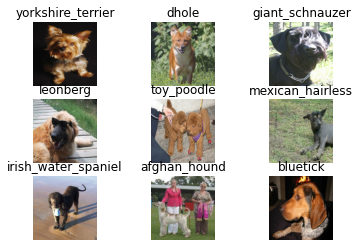

In [ ]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

## Prepare inputs
Once we verify the input data and augmentation are working correctly, we prepare dataset for training. The input data are resized to uniform IMG_SIZE. The labels are put into one-hot (a.k.a. categorical) encoding. The dataset is batched.

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

## Data augmentation
We can use preprocessing layers APIs for image augmentation.

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# Transfer learning from pre-trained weights


## Loading the latest EfficientNet weights
Here we download noisy-student version of EfficientNet B0

In [ ]:
%%capture

!wget "https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz"
!tar -xf "noisy_student_efficientnet-b0.tar.gz"


# Then use the script efficientnet_weight_update_util.py to convert ckpt file to h5 file.
# Download the script 
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
# Convert the ckpt file of weights to h5 file
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt "noisy_student_efficientnet-b0/model.ckpt" --o "efficientnetb0_notop.h5"

## First Step
To continue, we initialize the model with pre-trained noisy-student version of B0, and we fine-tune it on our own dataset.

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(weights="efficientnetb0_notop.h5", include_top=False, input_tensor=x)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="last_layer")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="PreTrainedEfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)


Epoch 1/25
187/187 [==============================] - 50s 151ms/step - loss: 4.1487 - accuracy: 0.3050 - val_loss: 1.0822 - val_accuracy: 0.6969
Epoch 2/25
187/187 [==============================] - 27s 143ms/step - loss: 1.9658 - accuracy: 0.5134 - val_loss: 0.8540 - val_accuracy: 0.7431
Epoch 3/25
187/187 [==============================] - 27s 143ms/step - loss: 1.5900 - accuracy: 0.5689 - val_loss: 0.7665 - val_accuracy: 0.7669
Epoch 4/25
187/187 [==============================] - 27s 142ms/step - loss: 1.4937 - accuracy: 0.5874 - val_loss: 0.7892 - val_accuracy: 0.7643
Epoch 5/25
187/187 [==============================] - 27s 143ms/step - loss: 1.4578 - accuracy: 0.5927 - val_loss: 0.7821 - val_accuracy: 0.7687
Epoch 6/25
187/187 [==============================] - 26s 141ms/step - loss: 1.4325 - accuracy: 0.5954 - val_loss: 0.7961 - val_accuracy: 0.7578
Epoch 7/25
187/187 [==============================] - 27s 142ms/step - loss: 1.3821 - accuracy: 0.6099 - val_loss: 0.7992 - val_ac

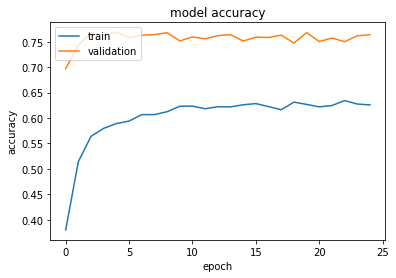

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

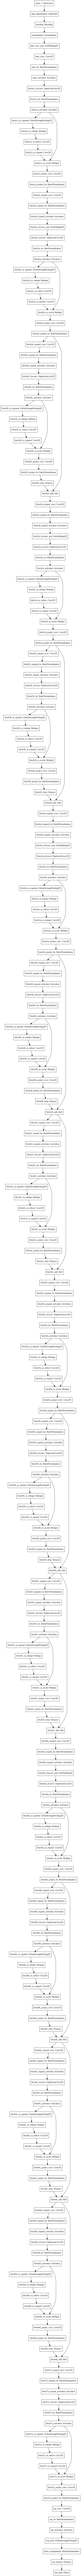

In [ ]:
tf.keras.utils.plot_model(model)

## Second Step
The second step is to unfreeze a number of layers, except BatchNormalizations layers, and fit the model using smaller learning rate.

Epoch 1/10
187/187 [==============================] - 35s 151ms/step - loss: 1.2236 - accuracy: 0.6538 - val_loss: 0.7159 - val_accuracy: 0.7983
Epoch 2/10
187/187 [==============================] - 27s 144ms/step - loss: 1.0031 - accuracy: 0.7032 - val_loss: 0.7163 - val_accuracy: 0.7973
Epoch 3/10
187/187 [==============================] - 27s 144ms/step - loss: 0.9266 - accuracy: 0.7219 - val_loss: 0.7140 - val_accuracy: 0.7983
Epoch 4/10
187/187 [==============================] - 27s 143ms/step - loss: 0.8930 - accuracy: 0.7298 - val_loss: 0.7184 - val_accuracy: 0.8001
Epoch 5/10
187/187 [==============================] - 27s 145ms/step - loss: 0.8657 - accuracy: 0.7395 - val_loss: 0.7210 - val_accuracy: 0.7986
Epoch 6/10
187/187 [==============================] - 27s 143ms/step - loss: 0.8182 - accuracy: 0.7466 - val_loss: 0.7265 - val_accuracy: 0.7975
Epoch 7/10
187/187 [==============================] - 27s 144ms/step - loss: 0.7873 - accuracy: 0.7527 - val_loss: 0.7244 - val_ac

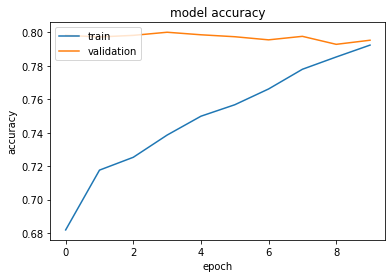

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)
plot_hist(hist)

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.save("fine-tuned_weights_using_StanfordDogs.h5")

# Calculate Separation Index

In [ ]:
ds_train = ds_train.unbatch()
ds_test = ds_test.unbatch()

encoded_y = tf.one_hot([i for i in range(NUM_CLASSES)], NUM_CLASSES).numpy()

In [ ]:
def calculate_separation_index(predictions, labels):
    Q = len(labels)
    N = NUM_CLASSES
    M = np.zeros([N, np.prod(predictions[0].shape)])
    global encoded_y
    for dog in range(N):
        the_sum = 0.0
        counter = 0.0
        for q in range(Q):
            if (labels[q] == encoded_y[dog]).all():
                the_sum += predictions[q]
                counter += 1

        the_sum /= counter
        the_sum = the_sum.reshape((np.prod(predictions[0].shape), ))
        M[dog, :] = the_sum

    I = 0
    for q in range(Q):
        vect_predictions = predictions[q].reshape((np.prod(predictions[0].shape), ))
        A = np.abs(vect_predictions - M)
        B = np.linalg.norm(A, axis=1)

        if (np.argmin(B) == np.argmax(labels[q])).all():
            I += 1

    return I / Q


### Make a sub-dataset containing 10 images of each class

In [ ]:
# Extract 10 images for each class out of train and test set and stack them together
sliced_ds_train = ds_train.filter(lambda x, y: tf.reduce_all(y == encoded_y[0])).take(10)
sliced_ds_test = ds_test.filter(lambda x, y: tf.reduce_all(y == encoded_y[0])).take(10)

for i in range(1, NUM_CLASSES):
    sliced_ds_train = sliced_ds_train.concatenate(ds_train.filter(lambda x, y: tf.reduce_all(y == encoded_y[i])).take(10))
    sliced_ds_test = sliced_ds_test.concatenate(ds_test.filter(lambda x, y: tf.reduce_all(y == encoded_y[i])).take(10))

sliced_ds_train = sliced_ds_train.shuffle(10*NUM_CLASSES).batch(1)
sliced_ds_test = sliced_ds_test.shuffle(10*NUM_CLASSES).batch(1)


In [ ]:
# Extract the labels out from the dataset
import numpy as np

train_set_labels = np.concatenate([y.numpy() for x, y in sliced_ds_train], axis=0)
test_set_labels = np.concatenate([y.numpy() for x, y in sliced_ds_test], axis=0)

In [ ]:
len(train_set_labels)

1200

### SI values on the output of some layers within the convolutional blocks

In [ ]:
SI_on_train_set = []
SI_on_test_set = []
selected_layers = []

for layer in model.layers:
    if layer.name.endswith("conv") or isinstance(layer, layers.Multiply) or isinstance(layer, layers.Add):
        layer_model = tf.keras.Model(model.input, layer.output)

        predictions = layer_model.predict(sliced_ds_train)
        value = calculate_separation_index(predictions, train_set_labels)
        SI_on_train_set.append(value)
        del predictions

        predictions = layer_model.predict(sliced_ds_test)
        value = calculate_separation_index(predictions, test_set_labels)
        SI_on_test_set.append(value)
        del predictions

        del layer_model

        name = f"{layer.__class__.__name__} - {layer.name}"
        selected_layers.append(name)

        print(f"Layer name: {name},  SI on tarin set: {round(SI_on_train_set[-1],3)},  SI on test set: {round(SI_on_test_set[-1],3)}")


Layer name: Conv2D - stem_conv,  SI on tarin set: 0.338,  SI on test set: 0.33
Layer name: DepthwiseConv2D - block1a_dwconv,  SI on tarin set: 0.739,  SI on test set: 0.73
Layer name: Multiply - block1a_se_excite,  SI on tarin set: 0.918,  SI on test set: 0.906
Layer name: Conv2D - block1a_project_conv,  SI on tarin set: 0.772,  SI on test set: 0.768
Layer name: Conv2D - block2a_expand_conv,  SI on tarin set: 0.99,  SI on test set: 0.986
Layer name: DepthwiseConv2D - block2a_dwconv,  SI on tarin set: 0.96,  SI on test set: 0.974
Layer name: Multiply - block2a_se_excite,  SI on tarin set: 0.923,  SI on test set: 0.922
Layer name: Conv2D - block2a_project_conv,  SI on tarin set: 0.827,  SI on test set: 0.802
Layer name: Conv2D - block2b_expand_conv,  SI on tarin set: 0.721,  SI on test set: 0.69
Layer name: DepthwiseConv2D - block2b_dwconv,  SI on tarin set: 0.768,  SI on test set: 0.789
Layer name: Multiply - block2b_se_excite,  SI on tarin set: 0.993,  SI on test set: 0.998
Layer name:

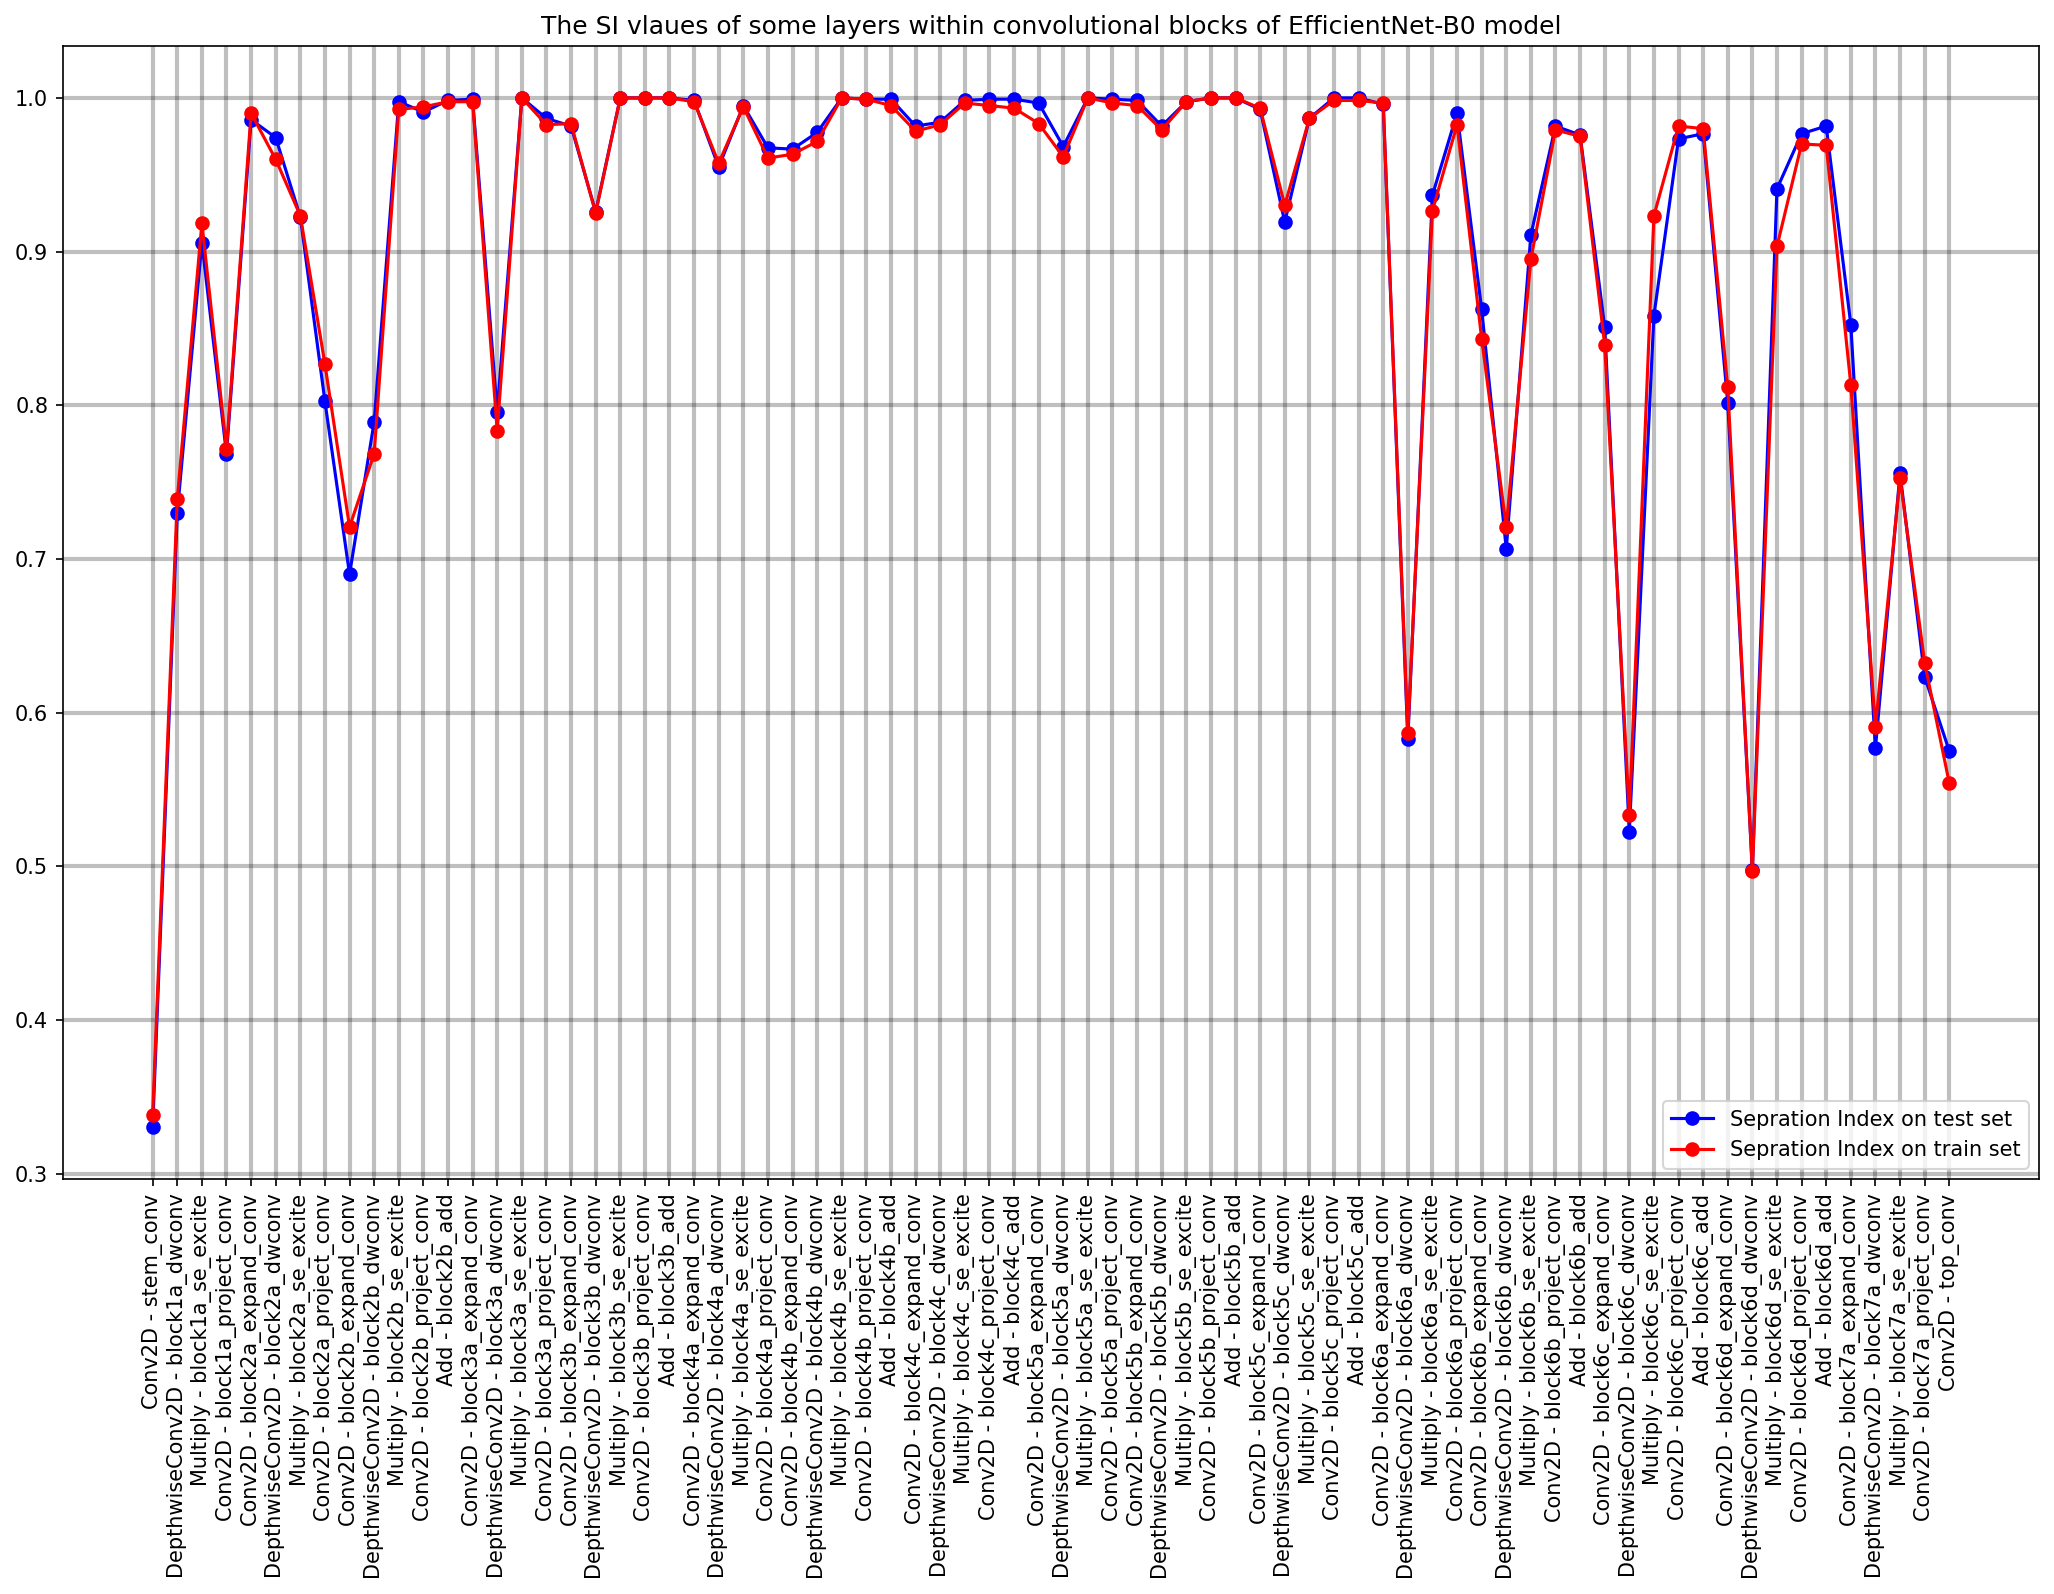

In [ ]:
# Plot Separation Index trend
# The SI vlaue is calculated of some layers within convolutional blocks in EfficientNet-B0
plt.figure(num=None, figsize=(17,10), dpi=150)
plt.title("The SI vlaues of some layers within convolutional blocks of EfficientNet-B0 model")

tick_marks = np.arange(len(selected_layers))
plt.xticks(tick_marks,selected_layers,rotation=90)

plt.plot(SI_on_test_set,'bo-')
plt.plot(SI_on_train_set,'ro-')

plt.legend(['Sepration Index on test set','Sepration Index on train set'], loc='lower right')
plt.grid(color='k', linestyle='-', linewidth=2, alpha=0.25)

plt.show()

### SI values for the dense layer (last layer of the model)

In [ ]:
# SI values for the dense layer (last layer of the model)

layer_model = tf.keras.Model(model.input, model.layers[-1].output)

predictions = layer_model.predict(sliced_ds_train)
value = calculate_separation_index(predictions, train_set_labels)
SI_dense_on_train_set = value
del predictions

predictions = layer_model.predict(sliced_ds_test)
value = calculate_separation_index(predictions, test_set_labels)
SI_dense_on_test_set = value
del predictions

del layer_model


print(f"SI values for the dense layer, on train set is {round(SI_dense_on_train_set,3)}, also on test set is {round(SI_dense_on_test_set,3)}")

SI values for the dense layer, on train set is 0.138, also on test set is 0.143


### Extra plots: Depths and number of parameters of colvolutional layers

In [ ]:
layers_types = []
num_parameters = []
layers_depths = []

for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        num_parameters.append(layer.count_params())
        layers_depths.append(layer.output_shape[-1])

        layers_types.append(layer.__class__.__name__)

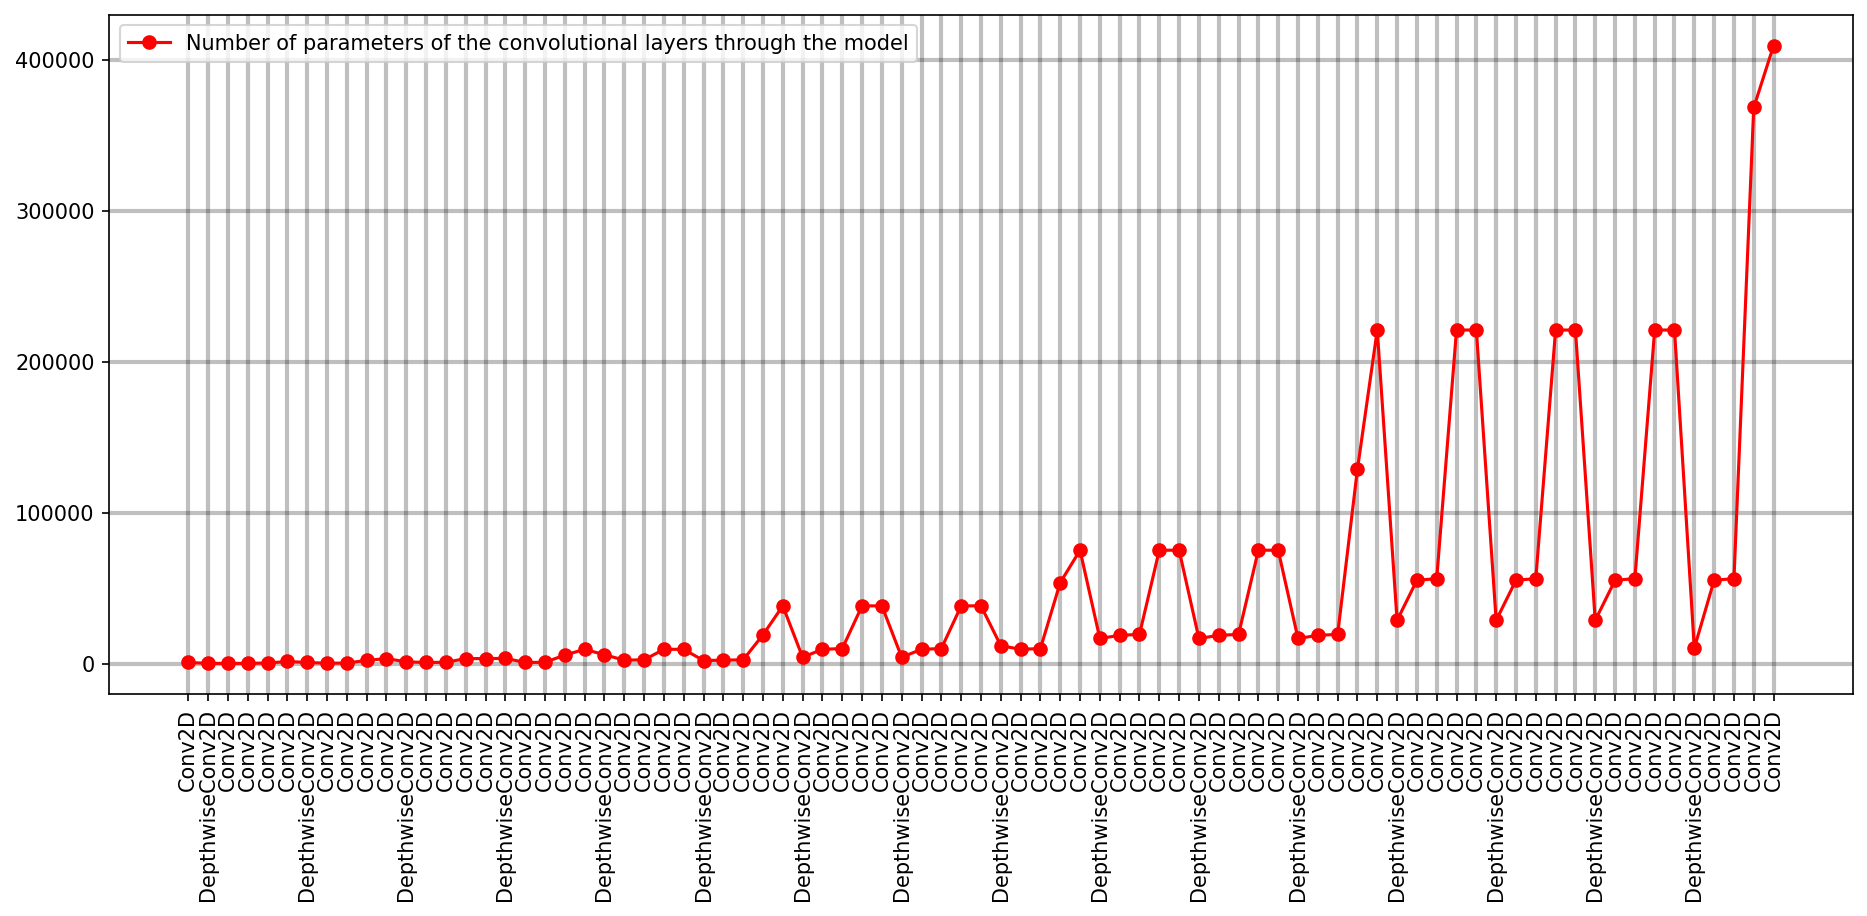

In [ ]:
# Plot increasing trend of the convolutional layers' parameters through EfficientNet-B0
plt.figure(num=None, figsize=(15,6), dpi=150)
tick_marks = np.arange(len(layers_types))
plt.xticks(tick_marks,layers_types,rotation=90)

plt.plot(num_parameters,'ro-')

plt.legend(['Number of parameters of the convolutional layers through the model'])
plt.grid(color='k', linestyle='-', linewidth=2, alpha=0.25)
plt.show()

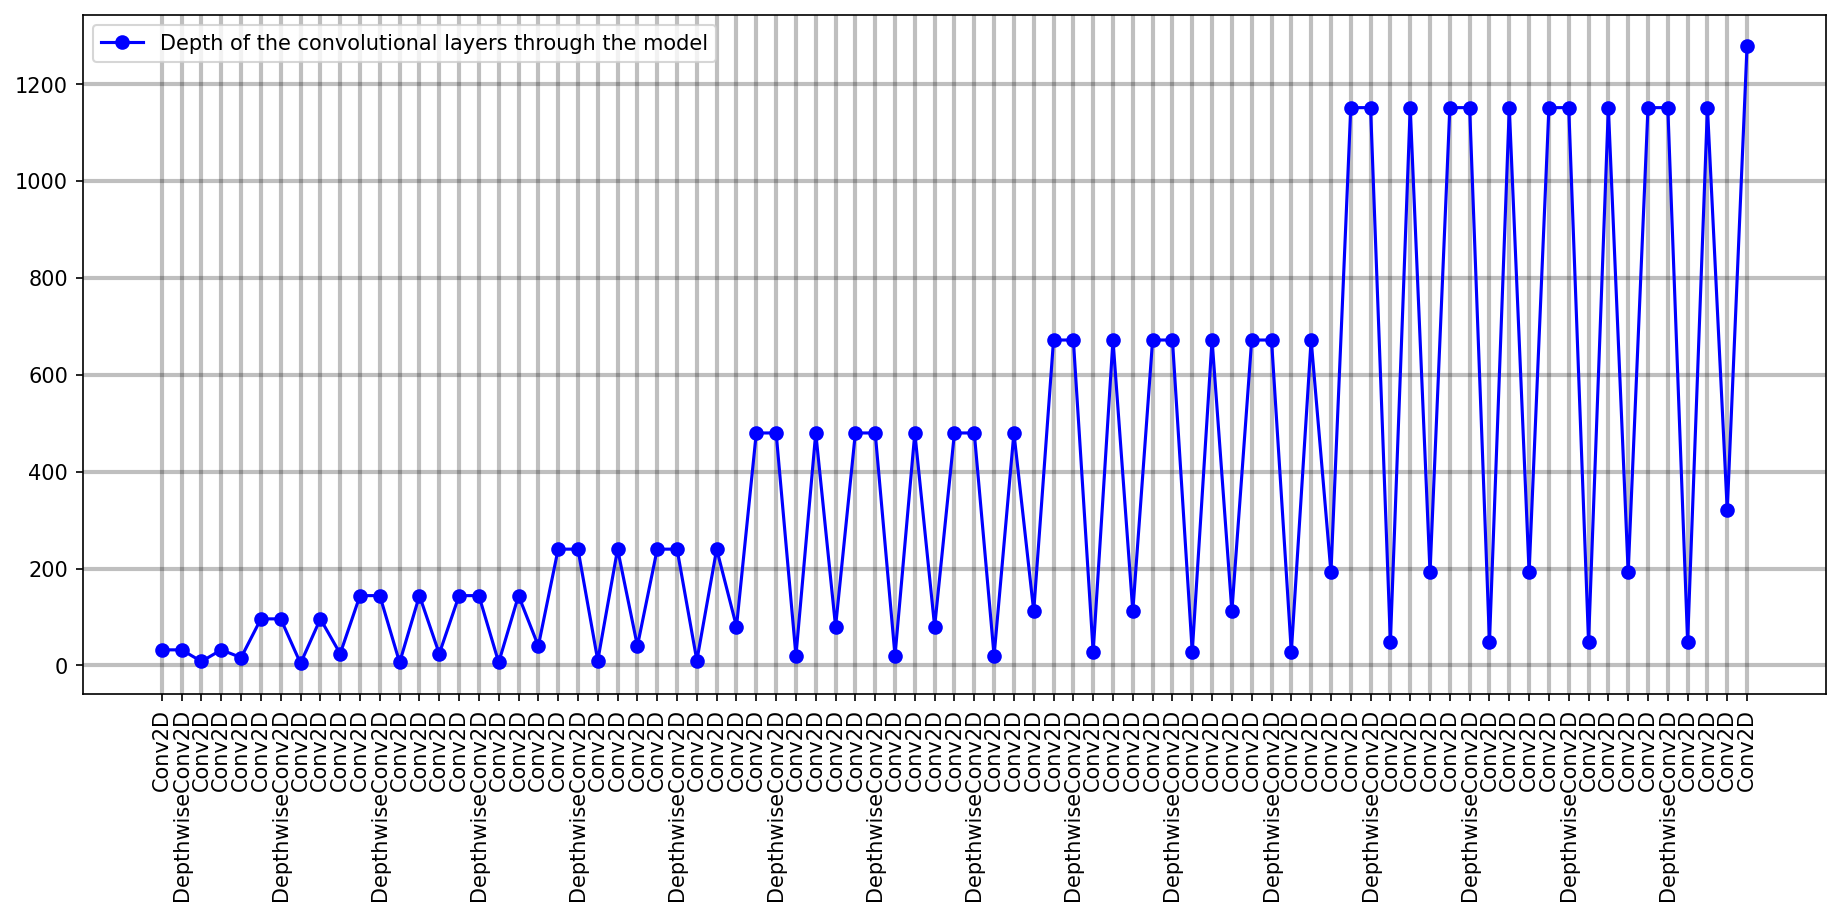

In [ ]:
# Plot increasing trend of the convolutional layers' depths through EfficientNet-B0
plt.figure(num=None, figsize=(15,6), dpi=150)
tick_marks = np.arange(len(layers_types))
plt.xticks(tick_marks,layers_types,rotation=90)

plt.plot(layers_depths,'bo-')

plt.legend(['Depth of the convolutional layers through the model'])
plt.grid(color='k', linestyle='-', linewidth=2, alpha=0.25)
plt.show()